In [43]:
%load_ext autoreload
%autoreload 2

from codes.Kalman import *
from scipy.integrate import odeint
from sklearn.linear_model import LinearRegression
import random

%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/home/administrateur/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Important parameters

In [93]:
# index of the unobserved component
i_unobs_comp = 0

# variance of the random white noise of z
variance_unobs_comp = 5

# variance of the observation error used in Kalman
variance_obs_comp = 0.0001

# number of Lorenz-63 times
nb_loop = 10

# number of SEM iterations
nb_iter_EM = 100

### Generate simulated data

In [45]:
# Lorenz-63 dynamical model
def Lorenz_63(x, dx, sigma, rho, beta):
    dx = zeros((3))
    dx[0] = sigma*(x[1]-x[0])
    dx[1] = x[0]*(rho-x[2])-x[1]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

# Lorenz-63 parameters
x0 = array([8, 0, 30]) # initial condition
dt = 0.001 # integration time step
sigma = 10; rho = 28; beta = 8/3 # physical parameters

# time and truth
t   = arange(0.01, nb_loop, dt)
x_t = odeint(Lorenz_63, x0, arange(0.01, nb_loop, dt), args=(sigma, rho, beta))

# observations
y = x_t.copy()
y = delete(y, i_unobs_comp, axis=1) # add noise here?

### V0: $x = [x_2, x_3]$

Text(0.5, 1.0, 'Observed components')

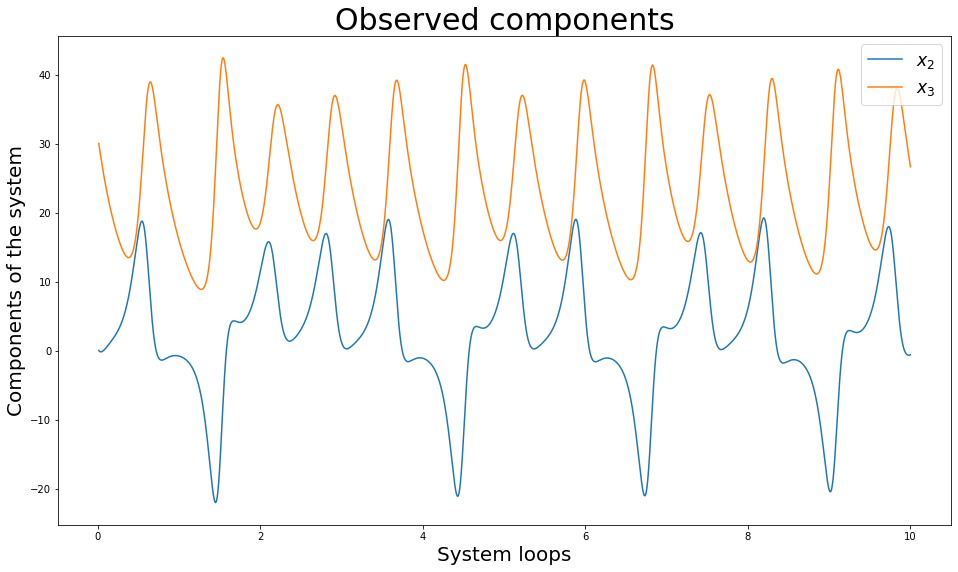

In [105]:
# state
xb = c_[y[:,0], y[:,1]]
B  = eye(2,2)*variance_obs_comp


# shapes
n = shape(xb)[1]
p = shape(y)[1]

# colors and labels of the components
tab_colors = ['C0', 'C1']
tab_labels = ['$x_2$', '$x_3$']

# plot the components
plot(t, xb)
xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Observed components', size=30)

In [112]:
# kalman parameters
H = eye(n)
R = variance_obs_comp*eye(p)
M  = eye(2,2)
Q  = eye(2,2)

# stochastic EM
x_s_V0, P_s_V0, M_V0, loglik_V0 = Kalman_EM(y, xb, B, M, Q, H, R, 10)

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


### V1: $x = [x_2, x_3, z_1]$

In [120]:
# state
xb = c_[x_s_V0, zeros(len(y))]
B  = [[0.9, 0.3, 0.3], [0.3, 0.9, 0.3], [0.3, 0.3, 0.9]]#eye(3,3)*variance_obs_comp # changer 

# shapes
n = shape(xb)[1]
p = shape(y)[1]

In [121]:
'''
##################
### FIGURE 1-a ###
##################

tab_colors = ['C0', 'C1', 'C2']
tab_labels = ['$y_2 \ (2^{nd} \ \mathrm{Lorenz \ component})$', '$y_3 \ (3^{rd} \ \mathrm{Lorenz \ component})$', '$z_1 = Random(\mathcal{N}(0,\sigma^2))$']
for i in [2,0,1]:
    plot(t, x[:,i], color=tab_colors[i], label=tab_labels[i])
xlabel('Time', size=30)
legend(loc=1, prop={'size': 30})
ylim([-25,45])
xlim([t[0],t[-1]])
'''

"\n##################\n### FIGURE 1-a ###\n##################\n\ntab_colors = ['C0', 'C1', 'C2']\ntab_labels = ['$y_2 \\ (2^{nd} \\ \\mathrm{Lorenz \\ component})$', '$y_3 \\ (3^{rd} \\ \\mathrm{Lorenz \\ component})$', '$z_1 = Random(\\mathcal{N}(0,\\sigma^2))$']\nfor i in [2,0,1]:\n    plot(t, x[:,i], color=tab_colors[i], label=tab_labels[i])\nxlabel('Time', size=30)\nlegend(loc=1, prop={'size': 30})\nylim([-25,45])\nxlim([t[0],t[-1]])\n"

In [153]:
# kalman parameters
H = delete(eye(n), 2, axis=0)
R = variance_obs_comp*eye(p)
M  = eye(3,3)
Q  = [[0.9, -0.1, -0.1], [-0.1, 0.9, -0.1], [-0.1, -0.1, 0.9]]

# stochastic EM
x_s_V1, P_s_V1, M_V1, loglik_V1 = Kalman_EM(y, xb, B, M, Q, H, R, 10)

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


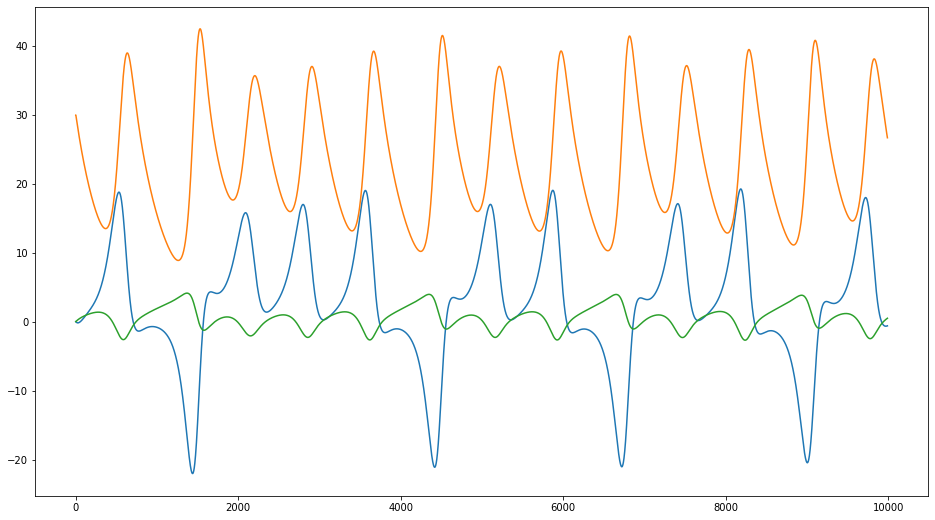

In [154]:
plot(x_s_V1)

In [131]:
##################
### FIGURE 1-b ###
##################

tab_labels = ['$x^s_2$', '$x^s_3$', '$x^s_1 \pm 1.96 \sqrt{P^s_1}$']
for i in [2,0,1]:
    plot(t, x_s_V1[:,i], color=tab_colors[i], label=tab_labels[i])
    fill_between(t, x_s_V1[:,i]-1.96*sqrt(P_s_V1[:,i,i]), x_s_V1[:,i]+1.96*sqrt(P_s_V1[:,i,i]),
                 facecolor=tab_colors[i], alpha=0.50)   
xlabel('Time', size=30)
legend(loc=1, prop={'size': 30})
ylim([-25,45])
xlim([t[0],t[-1]])

IndexError: list index out of range

### V2: $x = [x_2, x_3, z_1, z_2]$

Text(0.5, 1.0, 'Initial x')

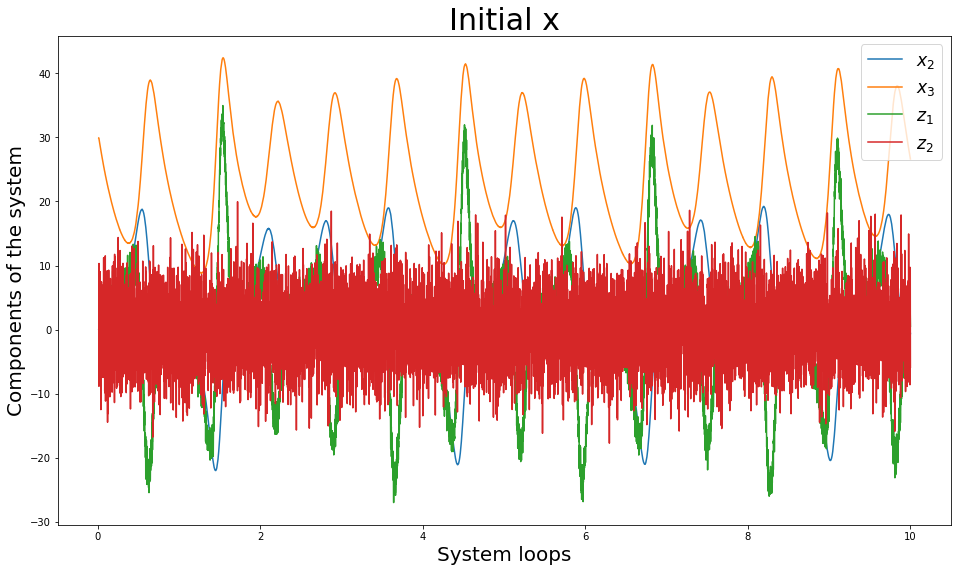

In [32]:
# state
z = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
x = c_[x, z]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# colors and labels of the components
tab_colors = ['C0', 'C1', 'C2', 'C3']
tab_labels = ['$x_2$', '$x_3$', '$z_1$', '$z_2$']

# plot the components
plot(t, x)
xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Initial x', size=30)

In [33]:
# kalman parameters
H = delete(eye(n), [2,3], axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V2, P_s_V2, M_V2, loglik_V2, x, x_f_V2 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [00:48<00:00,  1.60s/it]


Text(0.5, 1.0, 'Final x')

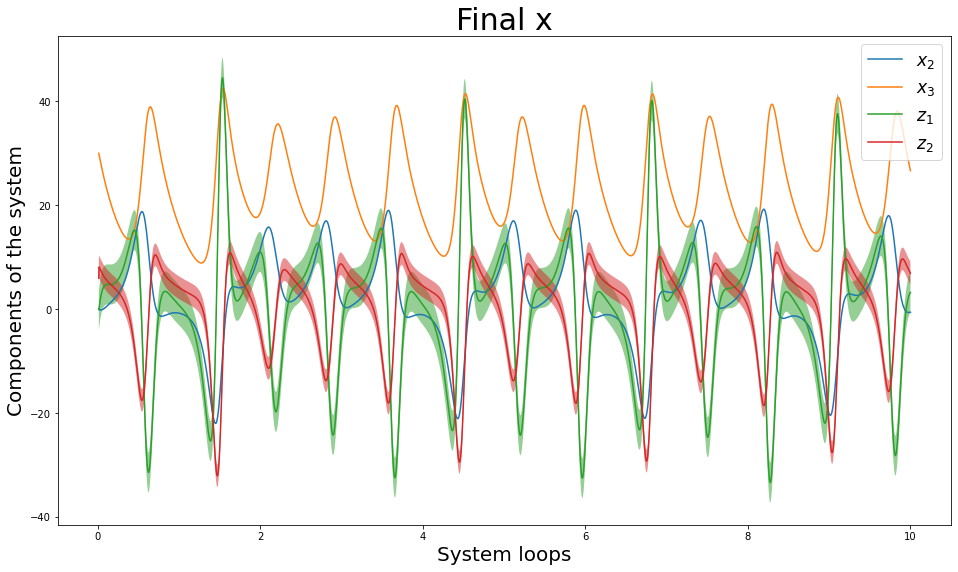

In [34]:
# plot the reconstructed components
for i in range(n):
    plot(t, x_s_V2[:,i], color=tab_colors[i])
    fill_between(t, x_s_V2[:,i]-1.96*sqrt(P_s_V2[:,i,i]), x_s_V2[:,i]+1.96*sqrt(P_s_V2[:,i,i]),
                 facecolor=tab_colors[i], alpha=0.50)

xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Final x', size=30)

### V3: $x = [x_2, x_3, z_1, z_2, z_3]$

Text(0.5, 1.0, 'Initial x')

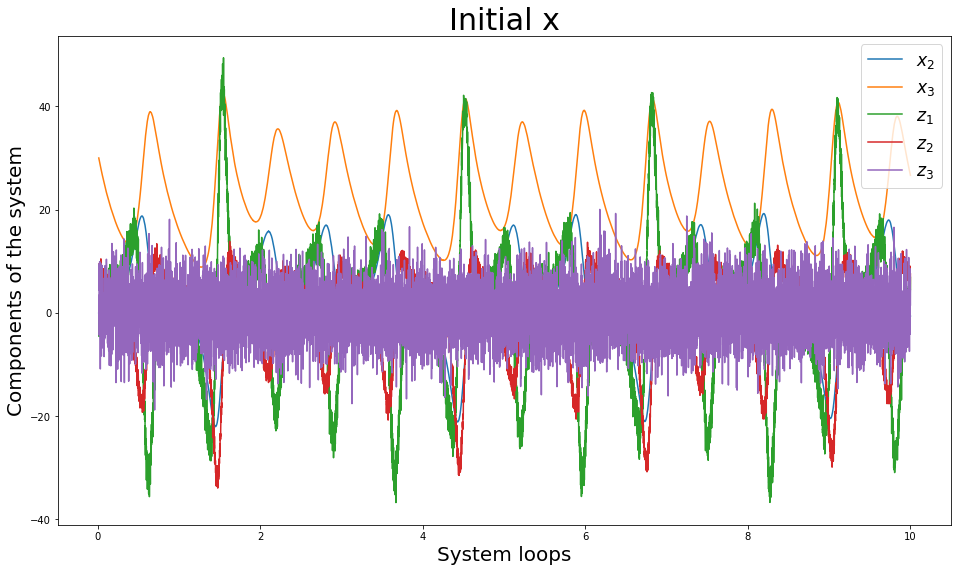

In [35]:
# state
z = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
x = c_[x, z]

# shapes
n = shape(x)[1]
p = shape(y)[1]

# colors and labels of the components
tab_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
tab_labels = ['$x_2$', '$x_3$', '$z_1$', '$z_2$', '$z_3$']

# plot the components
plot(t, x)
xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Initial x', size=30)

In [36]:
# kalman parameters
H = delete(eye(n), [2,3,4], axis=0)
R = variance_obs_comp*eye(p)

# stochastic EM
x_s_V3, P_s_V3, M_V3, loglik_V3, x,  x_f_V3 = Kalman_SEM(x, y, H, R, nb_iter_SEM)

100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


Text(0.5, 1.0, 'Final x')

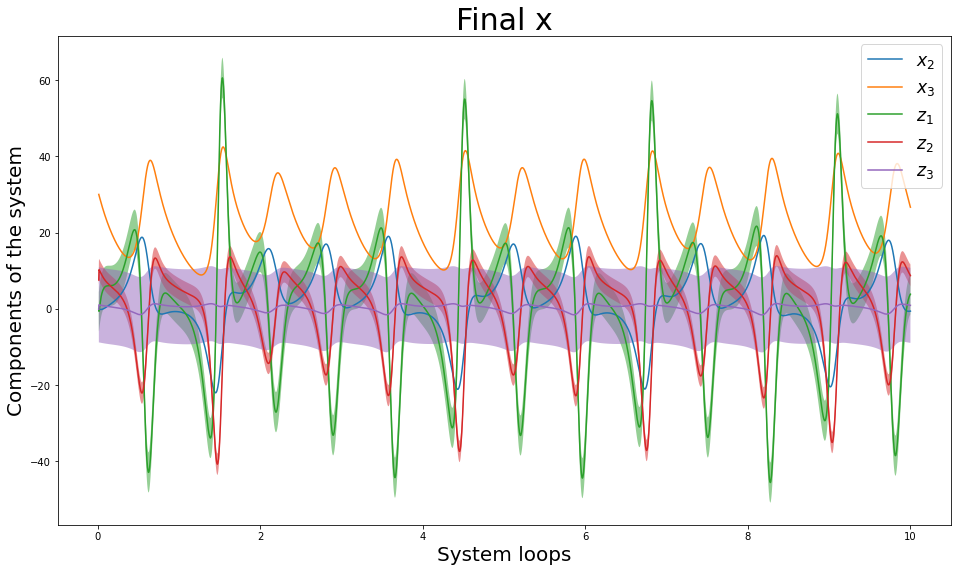

In [37]:
# plot the reconstructed components
for i in range(n):
    plot(t, x_s_V3[:,i], color=tab_colors[i])
    fill_between(t, x_s_V3[:,i]-1.96*sqrt(P_s_V3[:,i,i]), x_s_V3[:,i]+1.96*sqrt(P_s_V3[:,i,i]),
                 facecolor=tab_colors[i], alpha=0.50)

xlabel('System loops', size=20)
ylabel('Components of the system', size=20)
legend(tab_labels, loc=1, fontsize='xx-large')
title('Final x', size=30)

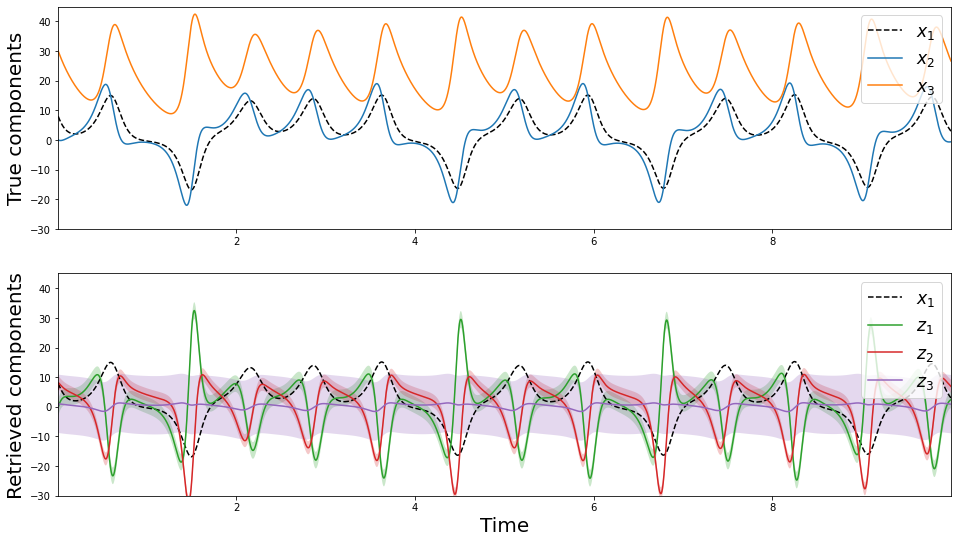

In [29]:
################
### FIGURE 2 ###
################

# true components
subplot(2,1,1)
tab_labels_fig1_a = ['$x_1$', '$x_2$', '$x_3$']
plot(t, x_t[:,i_unobs_comp], '--k')
plot(t, x_t[:,1], color='C0')
plot(t, x_t[:,2], color='C1')
ylabel('True components', size=20)
legend(tab_labels_fig1_a, loc=1, fontsize='xx-large')
ylim([-30,45])
xlim([t[0],t[-1]])

# retrieved components
subplot(2,1,2)
tab_labels_fig1_b = ['$x_1$', '$z_1$', '$z_2$', '$z_3$']
plot(t, x_t[:,i_unobs_comp], '--k')
plot(t, x_s_V1[:,2], color='C2')
plot(t, x_s_V2[:,3], color='C3')
plot(t, x_s_V3[:,4], color='C4')
fill_between(t, x_s_V1[:,2]-1.96*sqrt(P_s_V1[:,2,2]), x_s_V1[:,2]+1.96*sqrt(P_s_V1[:,2,2]),
                     facecolor='C2', alpha=0.25)
fill_between(t, x_s_V2[:,3]-1.96*sqrt(P_s_V2[:,3,3]), x_s_V2[:,3]+1.96*sqrt(P_s_V2[:,3,3]),
                     facecolor='C3', alpha=0.25)
fill_between(t, x_s_V3[:,4]-1.96*sqrt(P_s_V3[:,4,4]), x_s_V3[:,4]+1.96*sqrt(P_s_V3[:,4,4]),
                     facecolor='C4', alpha=0.25)
xlabel('Time', size=20)
ylabel('Retrieved components', size=20)
legend(tab_labels_fig1_b, loc=1, fontsize='xx-large')
ylim([-30,45])
xlim([t[0],t[-1]])

savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_true_hidden_components.png', bbox_inches='tight', dpi=400)

### Comparison of the different versions

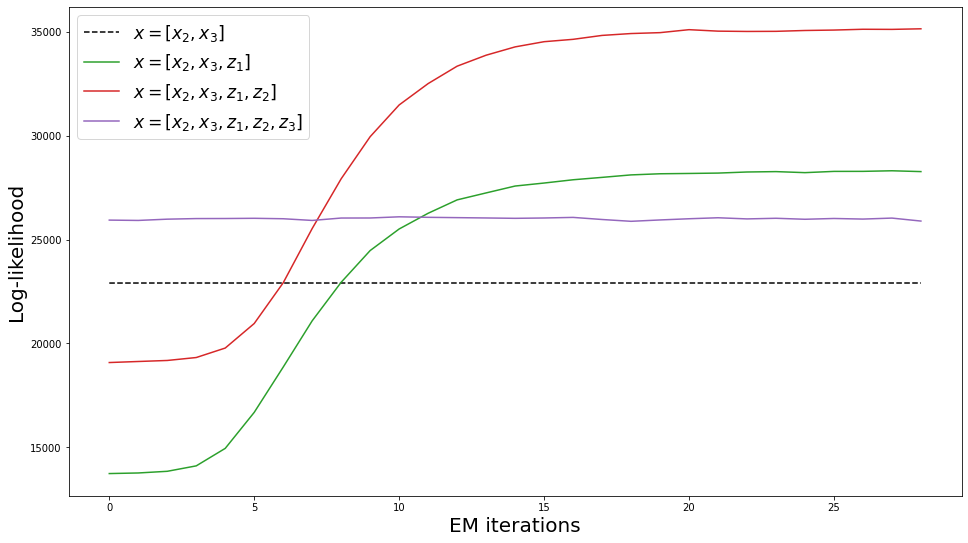

In [30]:
################
### FIGURE 3 ###
################

# likelihood of the different models
plot(loglik_V0[1:], '--k')
plot(loglik_V1[1:], color='C2')
plot(loglik_V2[1:], color='C3')
plot(loglik_V3[1:], color='C4')
xlabel('EM iterations', size=20)
ylabel('Log-likelihood', size=20)
legend(['$x = [x_2, x_3]$', '$x = [x_2, x_3, z_1]$', '$x = [x_2, x_3, z_1, z_2]$', '$x = [x_2, x_3, z_1, z_2, z_3]$'], loc=0, fontsize='xx-large')

savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_compare_likelihoods.png', bbox_inches='tight', dpi=400)

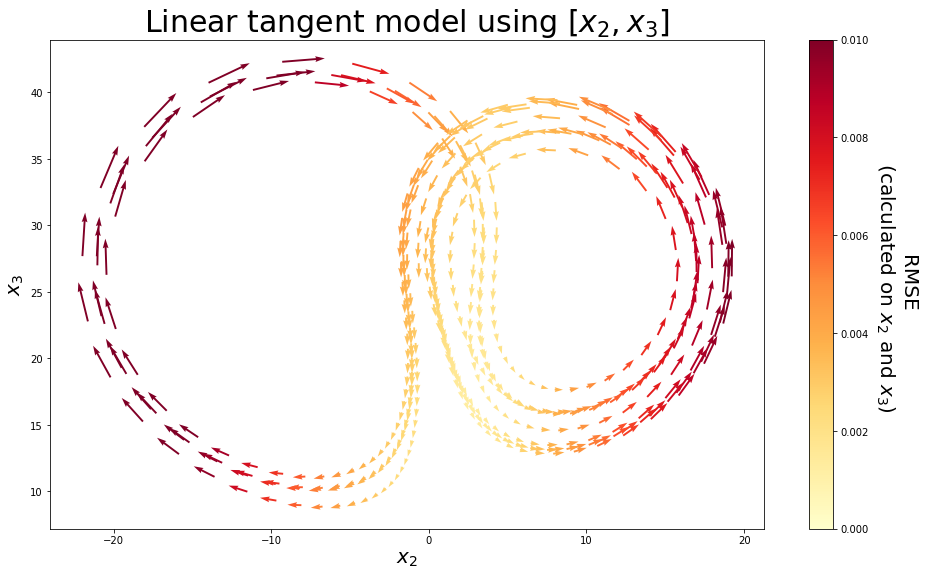

In [40]:
##################
### FIGURE 4-a ###
##################

# linear tangent model (using V0)
x_f_V0 = M_V0 @ x_t[:,1:3].T
x_f_V0 = x_f_V0.T
quiver(x_t[2:-1:20,1], x_t[2:-1:20,2],
      (x_f_V0[3::20,0]-x_t[2:-1:20,1]) / dt,
      (x_f_V0[3::20,1]-x_t[2:-1:20,2]) / dt,
      sqrt(mean((x_f_V0[2:-1:20,0:2]-x_t[2:-1:20,1:3])**2, axis=1)),
      cmap='YlOrRd')
clim([0,0.01])
xlabel('$x_2$', size=20)
ylabel('$x_3$', size=20)
cbar = plt.colorbar()
cbar.set_label('RMSE \n (calculated on $x_2$ and $x_3$)', rotation=270, size=20, labelpad=50)
title('Linear tangent model using $[x_2, x_3]$', size=30)

savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_linear_tangent_V0.png', bbox_inches='tight', dpi=400)

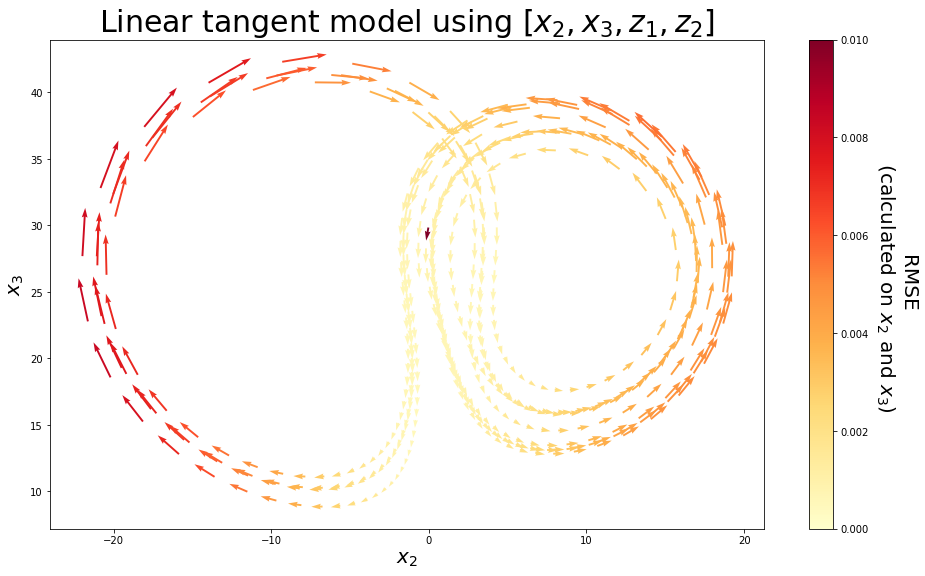

In [41]:
##################
### FIGURE 4-b ###
##################

# linear tangent model (using V2)
quiver(x_t[2:-1:20,1], x_t[2:-1:20,2],
      (x_f_V2[3::20,0]-x_t[2:-1:20,1]) / dt,
      (x_f_V2[3::20,1]-x_t[2:-1:20,2]) / dt,
      sqrt(mean((x_f_V2[2:-1:20,0:2]-x_t[2:-1:20,1:3])**2, axis=1)),
      cmap='YlOrRd')
clim([0,0.01])
xlabel('$x_2$', size=20)
ylabel('$x_3$', size=20)
cbar = plt.colorbar()
cbar.set_label('RMSE \n (calculated on $x_2$ and $x_3$)', rotation=270, size=20, labelpad=50)
title('Linear tangent model using $[x_2, x_3, z_1, z_2]$', size=30)

savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_linear_tangent_V2.png', bbox_inches='tight', dpi=400)

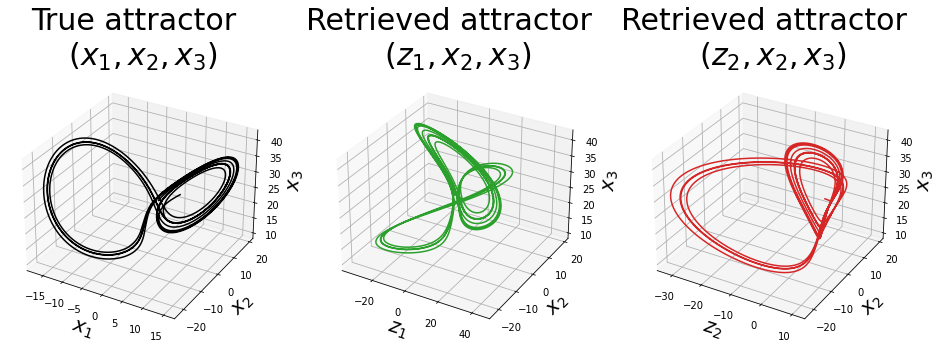

In [44]:
################
### FIGURE 5 ###
################

# new attractor using z1 and z2
fig = figure()
ax = fig.add_subplot(1, 3, 1, projection='3d')
plot(x_t[:,0], x_t[:,1], x_t[:,2], color='k')
ax.set_xlabel('$x_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)
ax.set_title('True attractor \n $(x_1, x_2, x_3)$', size=30)

ax = fig.add_subplot(1, 3, 2, projection='3d')
plot(x_s_V2[:,2], x_t[:,1], x_t[:,2], color='C2')
ax.set_xlabel('$z_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)
ax.set_title('Retrieved attractor \n $(z_1, x_2, x_3)$', size=30)

ax = fig.add_subplot(1, 3, 3, projection='3d')
plot(x_s_V2[:,3], x_t[:,1], x_t[:,2], color='C3')
ax.set_xlabel('$z_2$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)
ax.set_title('Retrieved attractor \n $(z_2, x_2, x_3)$', size=30)

savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_true_hidden_attractors.png', bbox_inches='tight', dpi=400)

In [45]:
# porcentage of improvement
RMSE_V0 = sum(sqrt(mean((x_f_V0[2:-1:20,0:2]-x_t[2:-1:20,1:3])**2)))
RMSE_V2 = sum(sqrt(mean((x_f_V2[2:-1:20,0:2]-x_t[2:-1:20,1:3])**2)))
print(100-RMSE_V2*100/RMSE_V0)

44.14213008899335


In [74]:
# write the ODEs
print('V0 ODE coefficients:')
print(around((M_V0-eye(2))/dt, 1))

print('V1 ODE coefficients:')
print(around((M_V1-eye(3))/dt, 1))

print('V2 ODE coefficients:')
print(around((M_V2-eye(4))/dt, 1))

print('V3 ODE coefficients:')
print(around((M_V3-eye(5))/dt, 1))

V0 ODE coefficients:
[[ 0.1 -0.1]
 [ 0.9 -0.1]]
V1 ODE coefficients:
[[  0.   -0.1   6.8]
 [  0.9  -0.1  -1.5]
 [ -8.9   1.1 -20.8]]
V2 ODE coefficients:
[[ -0.   -0.1   5.   -1.2]
 [  1.   -0.2  -1.2  -9. ]
 [-11.8   1.6 -20.9   1.2]
 [  0.6   1.    0.7 -15.1]]
V3 ODE coefficients:
[[-0.0000e+00 -1.0000e-01  3.7000e+00 -8.0000e-01 -0.0000e+00]
 [ 1.0000e+00 -2.0000e-01 -9.0000e-01 -7.2000e+00  2.0000e-01]
 [-1.6900e+01  2.2000e+00 -2.1300e+01  2.4000e+00 -9.4000e+00]
 [-4.0000e-01  1.7000e+00  1.1000e+00 -1.4800e+01 -1.7600e+01]
 [-7.2100e+01  2.3200e+01 -8.4000e+00  3.1800e+01 -1.0106e+03]]


In [75]:
# traces of linear tangent models
reg    = LinearRegression(fit_intercept=False).fit(x_t[:-1,], x_t[1:,])
M_true = reg.coef_

print('V0 trace of M:')
print(trace(M_V0))
print('V1 trace of M:')
print(trace(M_V1))
print('V2 trace of M:')
print(trace(M_V2))
print('V3 trace of M:')
print(trace(M_V3))
print('True trace of M:')
print(trace(M_true))

V0 trace of M:
1.9999470195555724
V1 trace of M:
2.9791442448870993
V2 trace of M:
3.963678489595788
V3 trace of M:
3.9530501267890776
True trace of M:
2.999754513851302


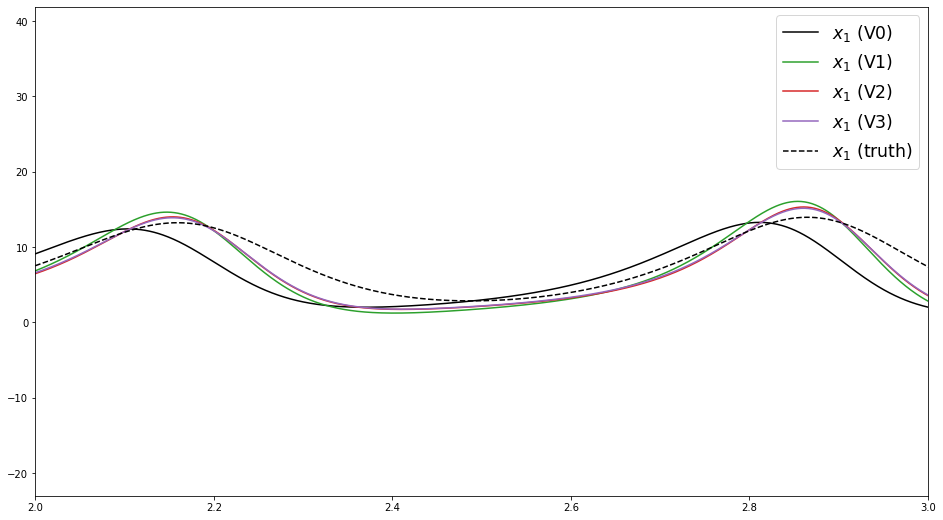

In [76]:
# regression between x_s (from V2) and x_1
#regress_V0 = LinearRegression(fit_intercept=False).fit((M_V0 @ x_t[:,1:3].T).T, x_t[:,0])
#x_hat_V0 = regress_V0.predict((M_V0 @ x_t[:,1:3].T).T)
regress_V0 = LinearRegression(fit_intercept=False).fit(x_s_V0, x_t[:,0])
x_hat_V0 = regress_V0.predict(x_s_V0)
regress_V1 = LinearRegression(fit_intercept=False).fit(x_s_V1, x_t[:,0])
x_hat_V1 = regress_V1.predict(x_s_V1)
regress_V2 = LinearRegression(fit_intercept=False).fit(x_s_V2, x_t[:,0])
x_hat_V2 = regress_V2.predict(x_s_V2)
regress_V3 = LinearRegression(fit_intercept=False).fit(x_s_V3, x_t[:,0])
x_hat_V3 = regress_V3.predict(x_s_V3)

# plot reconstructed x_1
#plot(t[1000:3000], x_hat_V0[1000:3000], color='k')
#plot(t[1000:3000], x_hat_V1[1000:3000], color='C2')
#plot(t[1000:3000], x_hat_V2[1000:3000], color='C3')
#plot(t[1000:3000], x_t[1000:3000,0], '--', color='k')
plot(t, x_hat_V0, color='k')
plot(t, x_hat_V1, color='C2')
plot(t, x_hat_V2, color='C3')
plot(t, x_hat_V3, color='C4')
plot(t, x_t[:,0], '--', color='k')
xlim([2,3])
legend(['$x_1$ (V0)', '$x_1$ (V1)', '$x_1$ (V2)', '$x_1$ (V3)', '$x_1$ (truth)'], loc=0, fontsize='xx-large')

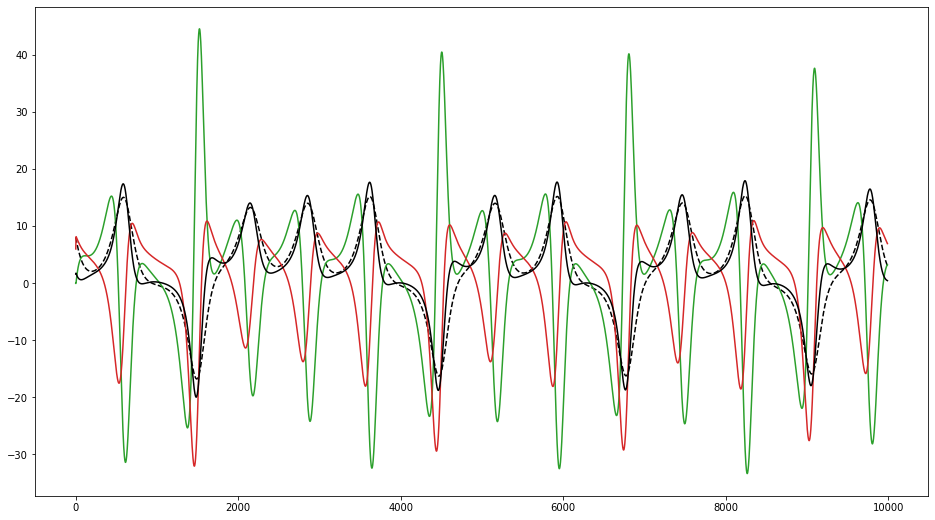

In [77]:
plot(x_t[:,0], '--k')
plot(x_s_V2[:,2], 'C2')
plot(x_s_V2[:,3], 'C3')
reg   = LinearRegression(fit_intercept=False).fit(x_s_V2, x_t[:,0])
x_hat = reg.predict(x_s_V2)
plot(x_hat, 'k')

Text(0.5, 0.92, 'Approximated attractor \n $(\\hat{x}_1, x_2, x_3)$')

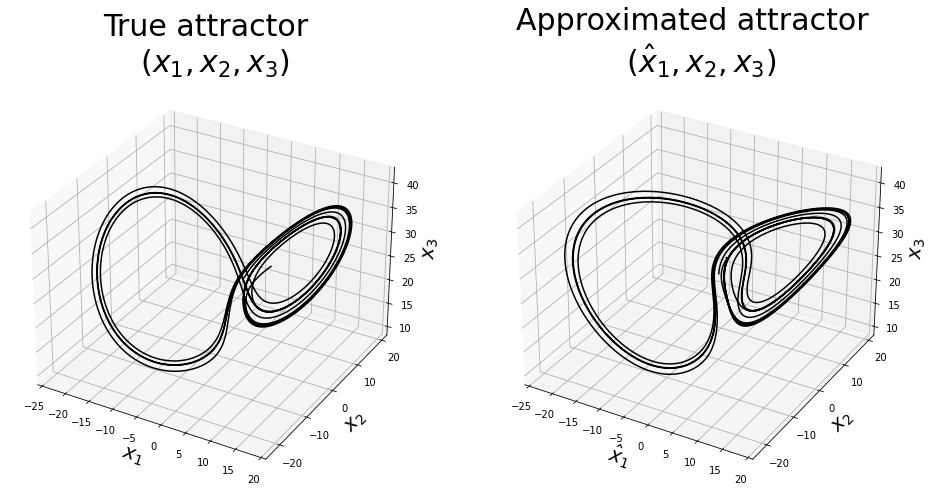

In [103]:
# new attractor using x1 hat
fig = figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(x_t[:,0], x_t[:,1], x_t[:,2], color='k')
ax.set_xlabel('$x_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)
ax.set_xlim([-25,20])
ax.set_title('True attractor \n $(x_1, x_2, x_3)$', size=30)

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(x_hat, x_s_V2[:,0], x_s_V2[:,1], color='k')
ax.set_xlabel('$\hat{x}_1$', size=20)
ax.set_ylabel('$x_2$', size=20)
ax.set_zlabel('$x_3$', size=20)
ax.set_xlim([-25,20])
ax.set_title('Approximated attractor \n $(\hat{x}_1, x_2, x_3)$', size=30)
#\n with $\hat{x}_1 = Lin.Comb.(x_2, x_3, z_1, z_2)$

In [78]:
reg_retrieved = LinearRegression(fit_intercept=False).fit(c_[x_hat[0:-1,], x_s_V2[0:-1,0], x_s_V2[0:-1,1]], c_[x_hat[1:,], x_s_V2[1:,0], x_s_V2[1:,1]])
M_retrieved   = reg_retrieved.coef_
print('Retrieved ODE coefficients:')
print(around((M_retrieved-eye(3))/dt, 1))

Retrieved ODE coefficients:
[[-17.1  15.1   0.3]
 [-23.4  17.    0.8]
 [ -1.8   2.2  -0. ]]


In [122]:
# relatioships between a2, b3, b2, b3

nb_exp = 50
nb_iter_SEM = 30
tab_regress_coef_V1 = zeros((nb_exp, 2))
tab_loglik_V1       = zeros((nb_exp, nb_iter_SEM))
tab_regress_coef_V2 = zeros((nb_exp, 3))
tab_loglik_V2       = zeros((nb_exp, nb_iter_SEM))

for i in range(nb_exp):
    
    print(i)
    
    random.seed(i)

    z_V1 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
    z_V2 = random.normal(loc=x_t[:,i_unobs_comp]*0, scale=variance_unobs_comp, size=shape(y)[0])
    
    # state
    x = c_[y[:,0], y[:,1], z_V1]
    
    # shapes
    n = shape(x)[1]
    p = shape(y)[1]
    
    # kalman parameters
    H = delete(eye(n), 2, axis=0)
    R = variance_obs_comp*eye(p)
    
    # stochastic EM
    x_s_V1, P_s_V1, M_V1, loglik_V1, tej1, tej2 = Kalman_SEM(x, y, H, R, nb_iter_SEM)
    
    # regression coefficients
    regress_coef = linalg.lstsq(diff(x_s_V1[:,0:2], axis=0), x_s_V1[0:-1,2], rcond=None)[0]
    tab_regress_coef_V1[i,:] = regress_coef*dt
    tab_loglik_V1[i,:] = loglik_V1
    
    # state
    x = c_[x, z_V2]

    # shapes
    n = shape(x)[1]
    p = shape(y)[1]
    
    # kalman parameters
    H = delete(eye(n), [2,3], axis=0)
    R = variance_obs_comp*eye(p)

    # stochastic EM
    x_s_V2, P_s_V2, M_V2, loglik_V2, tej1, tej2 = Kalman_SEM(x, y, H, R, nb_iter_SEM)
    
    # regression coefficients
    regress_coef = linalg.lstsq(diff(x_s_V1[:,0:3], axis=0), x_s_V2[0:-1,3], rcond=None)[0]
    tab_regress_coef_V2[i,:] = regress_coef*dt
    tab_loglik_V2[i,:] = loglik_V2

0


100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


1


100%|██████████| 30/30 [00:52<00:00,  1.73s/it]


2


100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


3


100%|██████████| 30/30 [00:51<00:00,  1.72s/it]


4


100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


5


100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


6


100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


7


100%|██████████| 30/30 [00:50<00:00,  1.67s/it]


8


100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


9


100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


10


100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


11


100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


12


100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


13


100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


14


100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


15


100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


16


100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


17


100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


18


100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


19


100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


20


100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


21


100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


22


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


23


100%|██████████| 30/30 [00:52<00:00,  1.74s/it]


24


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


25


100%|██████████| 30/30 [00:53<00:00,  1.78s/it]


26


100%|██████████| 30/30 [00:54<00:00,  1.83s/it]


27


100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


28


100%|██████████| 30/30 [00:55<00:00,  1.83s/it]


29


100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


30


100%|██████████| 30/30 [00:57<00:00,  1.93s/it]


31


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


32


100%|██████████| 30/30 [00:54<00:00,  1.82s/it]


33


100%|██████████| 30/30 [00:53<00:00,  1.79s/it]


34


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


35


100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


36


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


37


100%|██████████| 30/30 [00:53<00:00,  1.80s/it]


38


100%|██████████| 30/30 [00:55<00:00,  1.85s/it]


39


100%|██████████| 30/30 [00:54<00:00,  1.80s/it]


40


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


41


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


42


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


43


100%|██████████| 30/30 [00:53<00:00,  1.79s/it]


44


100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


45


100%|██████████| 30/30 [00:51<00:00,  1.71s/it]


46


100%|██████████| 30/30 [00:50<00:00,  1.67s/it]


47


100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


48


100%|██████████| 30/30 [00:50<00:00,  1.70s/it]


49


100%|██████████| 30/30 [00:51<00:00,  1.71s/it]


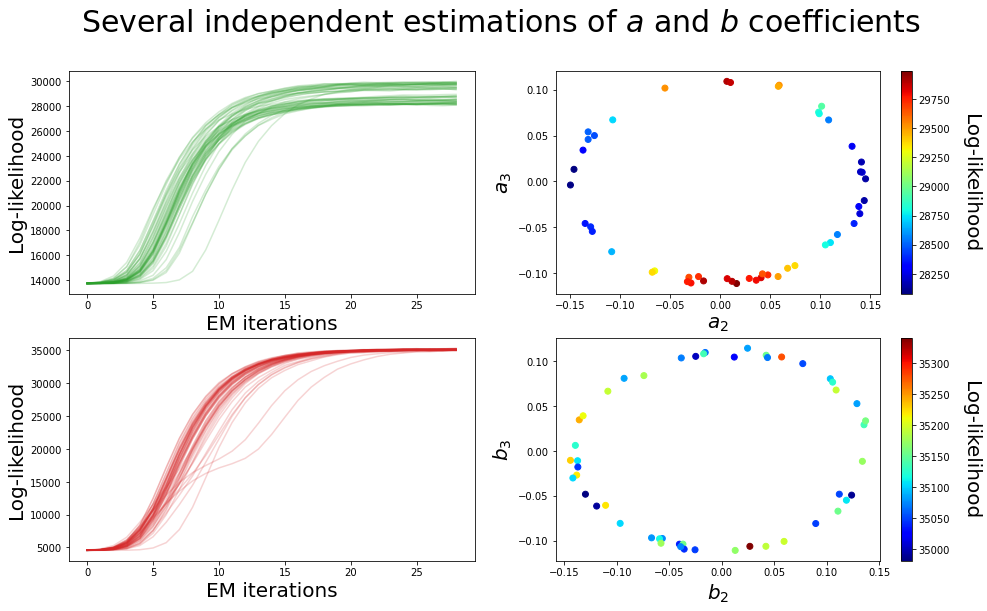

In [124]:
################
### FIGURE 6 ###
################

# note: remove "random.seed(11)" in Kalman.py

# parameters a2, a3, b2, b3
fig = figure()
ax = fig.add_subplot(2, 2, 1)
plot(tab_loglik_V1[:,1:].T, color='C2', alpha=0.2)
xlabel('EM iterations', size=20)
ylabel('Log-likelihood', size=20)

ax = fig.add_subplot(2, 2, 2)
scatter(tab_regress_coef_V1[:,0], tab_regress_coef_V1[:,1], c=tab_loglik_V1[:,-1], cmap='jet')
cbar_V1 = colorbar()
cbar_V1.set_label('Log-likelihood', rotation=270, size=20, labelpad=30)
xlabel('$a_2$', size=20)
ylabel('$a_3$', size=20)

ax = fig.add_subplot(2, 2, 3)
plot(tab_loglik_V2[:,1:].T, color='C3', alpha=0.2)
xlabel('EM iterations', size=20)
ylabel('Log-likelihood', size=20)

ax = fig.add_subplot(2, 2, 4)
scatter(tab_regress_coef_V2[:,0], tab_regress_coef_V2[:,1], c=tab_loglik_V2[:,-1], cmap='jet')
cbar_V1 = colorbar()
cbar_V1.set_label('Log-likelihood', rotation=270, size=20, labelpad=30)
xlabel('$b_2$', size=20)
ylabel('$b_3$', size=20)

suptitle('Several independent estimations of $a$ and $b$ coefficients', size=30)

savefig('/home/administrateur/Dropbox/Documents/Figures/Kalman/L63_coefficients_a_b.png', bbox_inches='tight', dpi=400)

In [80]:
from sklearn.metrics import r2_score

tab_R2 = zeros((7, 5))
Y = zeros((len(x_t)-2, 7))

# x2, x3, z1, z2, z3
X = x_s_V3[0:-2,:]

# x1
Y[:,0] = x_t[0:-2,0]

# diff(x1)
Y[:,1] = diff(x_t[0:-1,0])

# diff(x2)
Y[:,2] = diff(x_t[0:-1,1])

# diff(x3)
Y[:,3] = diff(x_t[0:-1,2])

# diff(diff((x1))
Y[:,4] = diff(diff(x_t[:,0]))

# diff(diff((x2))
Y[:,5] = diff(diff(x_t[:,1]))

# diff(diff((x3))
Y[:,6] = diff(diff(x_t[:,2]))

for i in range(7):
    for j in range(5):
        reg = LinearRegression(fit_intercept=False).fit(X[:,:j+1], Y[:,i])
        Y_hat = reg.predict(X[:,:j+1])
        tab_R2[i,j] = around(r2_score(Y[:,i], Y_hat), 2)

<AxesSubplot:>

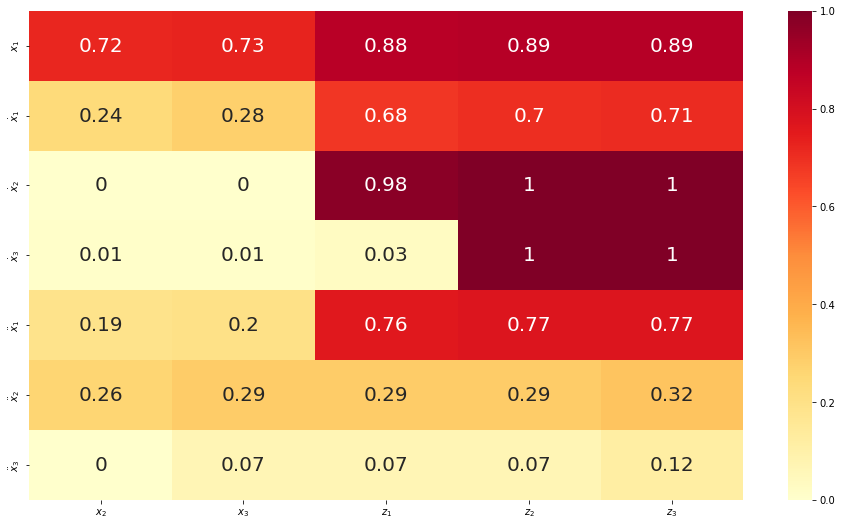

In [85]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(tab_R2, columns=['$x_2$', '$x_3$', '$z_1$', '$z_2$', '$z_3$'],
                  index=['$x_1$', '$\dot{x}_1$', '$\dot{x}_2$', '$\dot{x}_3$', '$\ddot{x}_1$', '$\ddot{x}_2$', '$\ddot{x}_3$'])
sns.heatmap(df, annot=True, annot_kws={"size":20}, cmap="YlOrRd")

In [87]:
# verification: z1 = alpha_2 diff(x2) + alpha_3 diff(x3)

# diff(x2) and diff(x3)
X = c_[diff(x_t[0:-1,1]), diff(x_t[0:-1,2])]

# z1
Y = x_s_V1[0:-2,2]

reg = LinearRegression(fit_intercept=False).fit(X, Y)
Y_hat = reg.predict(X)
print(around(r2_score(Y, Y_hat), 3))

0.999


In [94]:
# verification: z2 = beta_1 diff(z1) beta_2 diff(diff(x2)) + beta_3 diff(diff(x3))

# z1, diff(x2), diff(x3)
X = c_[diff(x_s_V1[0:-1,2]), diff(x_t[0:-1,1]), diff(x_t[0:-1,2])]

# z2
Y = x_s_V2[0:-2,3]

reg = LinearRegression(fit_intercept=False).fit(X, Y)
Y_hat = reg.predict(X)
print(around(r2_score(Y, Y_hat), 3))

0.992
